In [2]:
### Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from diffpy.mpdf import *
from diffpy.structure import loadStructure

### Set all plots to be inline
%matplotlib notebook

In [3]:
### Load in the refined atomic structure produced by the atomic PDF fits
struc = loadStructure('MnOfitStruc.stru')
print(struc)

lattice=Lattice(a=4.43065, b=4.43065, c=4.43065, alpha=90.6096, beta=90.6096, gamma=90.6096)
Mn   0.000000 0.000000 0.000000 1.0000
Mn   0.000000 0.500000 0.500000 1.0000
Mn   0.500000 0.000000 0.500000 1.0000
Mn   0.500000 0.500000 0.000000 1.0000
O    0.500000 0.500000 0.500000 1.0000
O    0.500000 0.000000 0.000000 1.0000
O    0.000000 0.500000 0.000000 1.0000
O    0.000000 0.000000 0.500000 1.0000


<IPython.core.display.Javascript object>


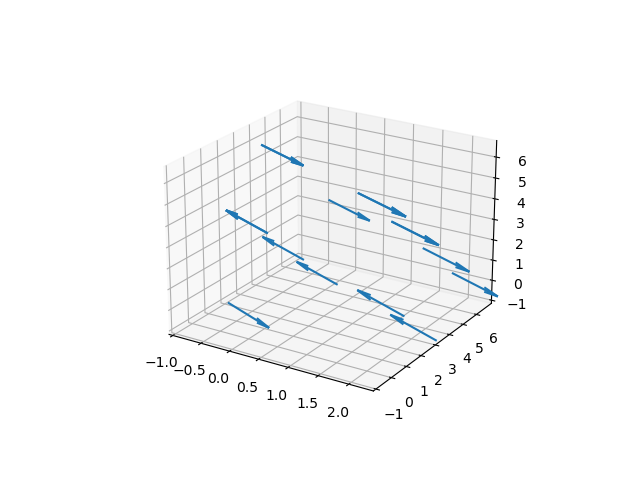

In [4]:
### Create the Mn2+ magnetic species
k = np.array([0.5,0.5,0.5]) # known propagation vector for MnO
svec = np.array([1.0,-1.0,0.0]) # spins point parallel or anti-parallel to this direction
MnList = [0,1,2,3] # list of indices of the Mn atoms in the unit cell
msp = MagSpecies(struc,strucIdxs=MnList,ffparamkey='Mn2',rmaxAtoms=50,basisvecs=svec,
                kvecs=k,label='Mn')

### Create the magnetic structure object and load in the Mn2+ species
mstr=MagStructure()
mstr.loadSpecies(msp)

### Generate the atom and spin arrays
mstr.makeAll()

### Visualize the magnetic structure to make sure it looks right
uc = struc[:4].xyz
visatoms = uc.copy()
visatoms = np.concatenate((visatoms,visatoms+np.array([0,0,1]),visatoms+np.array([0,1,0]),visatoms+np.array([0,0,1])))
visatoms = struc.lattice.cartesian(visatoms)
visspins = mstr.spinsFromAtoms(visatoms,fractional=False)
mstr.visualize(visatoms,visspins)

In [5]:
### Extract the mPDF data (i.e. atomic PDF fit residual), load into SrFit Profile
r, d = getDiffData('MnOfit_atomicStructureOnly.fgr')

from diffpy.srfit.fitbase import Profile

profile = Profile()
profile.setObservedProfile(r, d)


### Create the MPDFcalculator
mc = MPDFcalculator(mstr) # load the magnetic structure into the MPDFcalculator
mc.rmin = profile.xobs.min()
mc.rmax = profile.xobs.max()


### Make the FitContribution
from diffpy.srfit.fitbase import FitContribution
mfit = FitContribution('mfit')
mfit.setProfile(profile)

# Define the function that will calculate the mPDF
def mpdf(parascale, ordscale):
    mc.paraScale, mc.ordScale = parascale, ordscale
    dr = mc.calc(both=True)[2] # calculate the "unnormalized" mPDF
    return dr

mfit.registerFunction(mpdf)
mfit.setEquation("mpdf(parascale, ordscale)")


### Make the FitRecipe
### Make the FitRecipe and add the relevant variables
from diffpy.srfit.fitbase import FitRecipe
recipe = FitRecipe()

# give the PDFContribution to the FitRecipe
recipe.addContribution(mfit)

# add the mPDF variables
recipe.addVar(mfit.parascale, 4)
recipe.addVar(mfit.ordscale, 0.5)

Refine using scipy's least-squares optimizer:
  variables: ['parascale', 'ordscale']
  initial values: [4.  0.5]
  final values: [2.87052825 1.20719688]


<IPython.core.display.Javascript object>


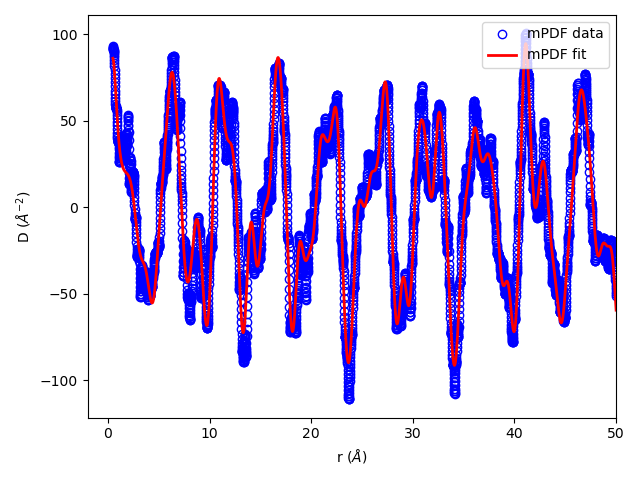

In [6]:
### Run the refinement

# Turn off printout of iteration number.
recipe.clearFitHooks()

# Initial structural fit
print("Refine using scipy's least-squares optimizer:")
print("  variables:", recipe.names)
print("  initial values:", recipe.values)

from scipy.optimize import least_squares

least_squares(recipe.residual, recipe.values)
print("  final values:", recipe.values)

### Plot the results
fit = mfit.evaluateEquation("mpdf")

ax=plt.figure().add_subplot(111)
ax.plot(r, d, 'bo', label="mPDF data", markerfacecolor='none', markeredgecolor='b')
ax.plot(r, fit, 'r-', lw=2, label="mPDF fit")
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"D ($\AA^{-2}$)")
ax.set_xlim(xmax=mc.rmax)
plt.legend(loc=1)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


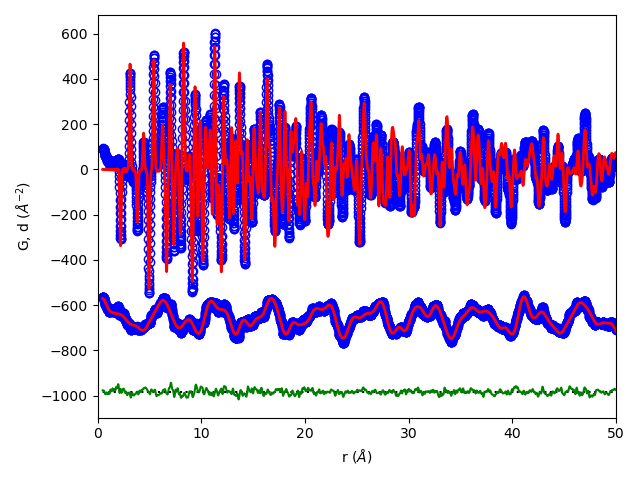

0.07317021765912612


In [10]:
### Plot the total PDF (atomic + magnetic) with the total fit
r, gobs, gcalc, gdiff = read_fgr('MnOfit_atomicStructureOnly.fgr')
mdiff = d - fit

offset1 = 1.2*gobs.min()
offset2 = offset1 - 8*mdiff.max()

# Make the figure.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r,gobs,marker='o',mfc='none',mec='b',linestyle='none') ### total observed PDF pattern 
ax.plot(r,gcalc,'r-',lw=2) ### calculated atomic PDF
ax.plot(r,d+offset1,marker='o',mfc='none',mec='b',linestyle='none') ### residual from atomic PDF fit
ax.plot(r,fit+offset1,'r-',lw=2) ### calculated mPDF
ax.plot(r,np.zeros_like(r)+offset2,'k:')
ax.plot(r,mdiff+offset2,'g-') ### overall fit residual after including atomic and magnetic PDFs
ax.set_xlim(xmin=0,xmax=mc.rmax)
ax.set_xlabel('r ($\AA$)')
ax.set_ylabel('G, d ($\AA^{-2}$)')
plt.tight_layout()
plt.show()

Rw = np.sqrt(np.sum((mdiff)**2)/np.sum(gobs**2))
print(Rw)

In [8]:
plt.close('all')